# Modelo de expansão em Cluster - Nanocelulose

Neste notebook mostro como implementei um modelo de previsão de energia total de fibras de nanocelulose por meio de uma expansão em cluster. A ideia é contar o número de cadeias de celulose em cada fibra e associar isto a um termo de energia, em seguida considerando pares de cadeias, trios e quartetos. No caso de pares de cadeias, dois tipos foram considerados: pares horizontais (notação $2_h$), que interagem por meio de pontes de hidrogênio e pares diagonais (notação $2_d$), que interagem por meio de interações de van der Waals. No caso de quartetos de cadeias, dois tipos também foram considerados: formato diamante ($4_d$) e formato losango ($4_l$). De um modo geral, a expressão para a energia total de uma cadeia de celulose nesse modelo é dada pela expressão

$$ \Delta E_f = \alpha_1 n_1 + \alpha_{2_h} n_{2_h} + \alpha_{2_d} n_{2_d}+ \alpha_{3} n_3 + \alpha_{4_d} n_{4_d} + \alpha_{4_l} n_{4_l}$$

A tarefa então é basicamente ajustar estes parâmetros $\alpha_i$ utilizando a geometria das fibras e suas energias de formação a partir de uma única cadeia calculadas pelo VASP por DFT-PBE+vdW após relaxação iônica.

### DNA das fibras

As fibras são identificadas por uma sequência de letras, batizada de <i>DNA</i> da fibra. Este decodifica os passos que foram realizados para se construir a fibra a partir de uma única cadeia que foi sendo transladada ao longo das direções perpendiculares à seção transversal da fibra e copiada em uma nova posição. Tal código deve ser lido da seguinte maneira:

<ul>
    <li> <b>a</b>: inserir nova cadeia à esquerda e acima da cadeia atual </li>
    <li> <b>b</b>: nova cadeia acima e à direita </li>
    <li> <b>c</b>: nova cadeia à direita </li>
    <li> <b>d</b>: nova cadeia abaixo e à direita </li>
    <li> <b>e</b>: nova cadeia abaixo e à esquerda </li>
    <li> <b>f</b>: nova cadeia à esquerda </li>
</ul>

### Alguns exemplos de fibras que foram utilizadas nos cálculos DFT

Os labels das fibras estão acima das imagens das mesmas.

<table>
    <tr>
        <td style="text-align:center"><b>ccafacc</b> </td>
        <td style="text-align:center"><b>cbffbcbffbc</b> </td>
    </tr>
    <tr>
        <td><img src="ccafacc.jpg" /></td>
        <td><img src="cbffbcbffbc.jpg" /></td>
    </tr>
    <tr>
        <td style="text-align:center"><b>bfb</b> </td>
        <td style="text-align:center"><b>ffbccaff</b> </td>
    </tr>
    <tr>
        <td><img src="bfb.jpg" /></td>
        <td><img src="ffbccaff.jpg" /></td>
    </tr>
</table>

Ao todo foram utilizadas 15 estruturas diferentes para realizar o ajuste dos parâmetros do modelo de cluster.

### Parte 1 - treinamento da regressão linear

Primeiramente importamos biliotecas necessárias para manipulação dos dados e treinamento (ou ajuste) do modelo

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
%matplotlib notebook

Os dados dos cálulos DFT estão num arquivo de texto

In [40]:
# read data from file
with open("regression_data.dat") as file:
	lines = file.readlines()

As informações são armazenadas em três listas: labels com os DNAs, desc com os $n_i$ e targets com as energias totais calculadas pelo VASP.

In [41]:
# labels, descriptors and targets
labels = []
desc = []
targets = []

for line in lines:
	linestrip = line.strip().split(',')
	labels.append(linestrip[0])
	desc.append(linestrip[1:-1])
	targets.append(linestrip[-1])

Agora obtemos a energia de uma única cadeia isolada a partir de um cálculo no VASP e usamos a mesma para calcular as energias de formação $\Delta E_f$ de cada fibra. Estas energias são armazenadas no vetor energies.

In [42]:
e_sc = -248.30396698

energies = np.zeros(len(targets))
for i in range(len(labels)):
    # precisamos de n + 1 cadeias para formar a fibra
    energies[i] += float(targets[i]) - (len(labels[i])+1) * e_sc
    print('DNA: {:20s} -> E_f = {:7.3f}'.format(labels[i],energies[i]))

DNA: cbffbccaf            -> E_f = -18.199
DNA: ccbffaccbffaccbff    -> E_f = -36.047
DNA: ccbfffbcc            -> E_f = -18.307
DNA: cbffacccaffbc        -> E_f = -27.399
DNA: ccafaccafacc         -> E_f = -23.965
DNA: cbffbcbffbc          -> E_f = -21.726
DNA: cccbffffbccc         -> E_f = -25.314
DNA: ccccafffbccaf        -> E_f = -27.388
DNA: ccbffaccbffacc       -> E_f = -29.202
DNA: cbffbc               -> E_f = -11.468
DNA: ffbccaff             -> E_f = -16.085
DNA: ccafacc              -> E_f = -13.587
DNA: ccbffbccbff          -> E_f = -22.817
DNA: bfb                  -> E_f =  -4.564
DNA: cccaffbc             -> E_f = -15.889


Separamos os dados em dois numpy arrays, verificamos se temos realmente 15 entradas de dados e por fim separamos 20% dos dados para teste e 80% para treinamento.

In [288]:
# descriptors and targets in np arrays
y = np.array(energies, dtype=float)
X = np.array(desc, dtype=float)

print('Numero de dados: {:d}'.format(np.shape(X)[0]))
print('Dimensao dos descritores: {:d}'.format(np.shape(X)[1]))

# split train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# separamos os labales do train e test sets aqui
lab_train = [labels[np.where(y == i)[0][0]] for i in y_train]
lab_test = [labels[np.where(y == i)[0][0]] for i in y_test]

Numero de dados: 15
Dimensao dos descritores: 6


Utilizamos um regressor linear do Scikit-learn e treinamos o mesmo com os descritores e labels do set de treinamento.

In [289]:
# linear regressor training
reg = LinearRegression().fit(X_train, y_train)

Verificamos o score deste regressor tanto no train quanto no test set. A métrica utilizada é o $R^2$.

In [290]:
# show score for train and test sets

score_train = reg.score(X_train, y_train)
score_test = reg.score(X_test, y_test)

print('Score train set: {:.8f}\nScore test set: {:.8f}'.format(score_train, score_test))

Score train set: 0.99938095
Score test set: 0.99644438


Temos resultados muito bons! Podemos agora prever alguns valores de energia e comparar com os valores dados, assim como verificar seu erro absoluto (AE).

In [291]:
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

print('-' * 40 + ' Train set ' + '-' * 40)
for l, i,j in zip(lab_train, y_train, y_train_pred):
    print('DNA: {:20s} -> E calculada: {:9.3f}\tPredita: {:9.3f}\tAE: {:6.3f}%'.format(l, i, j, abs(i - j)*100/abs(i)))

print('\n' + '-' * 40 + ' Test set ' + '-' * 41)
for l, i,j in zip(lab_test, y_test, y_test_pred):
    print('DNA: {:20s} -> E calculada: {:9.3f}\tPredita: {:9.3f}\tAE: {:6.3f}%'.format(l, i, j, abs(i - j)*100/abs(i)))


---------------------------------------- Train set ----------------------------------------
DNA: bfb                  -> E calculada:    -4.564	Predita:    -4.445	AE:  2.602%
DNA: cbffbcbffbc          -> E calculada:   -21.726	Predita:   -22.178	AE:  2.080%
DNA: ccbffaccbffacc       -> E calculada:   -29.202	Predita:   -29.196	AE:  0.021%
DNA: ccbfffbcc            -> E calculada:   -18.307	Predita:   -18.481	AE:  0.947%
DNA: ccbffaccbffaccbff    -> E calculada:   -36.047	Predita:   -35.847	AE:  0.555%
DNA: cccaffbc             -> E calculada:   -15.889	Predita:   -15.895	AE:  0.037%
DNA: ccafaccafacc         -> E calculada:   -23.965	Predita:   -24.025	AE:  0.250%
DNA: ccccafffbccaf        -> E calculada:   -27.388	Predita:   -27.347	AE:  0.147%
DNA: ffbccaff             -> E calculada:   -16.085	Predita:   -15.895	AE:  1.179%
DNA: ccbffbccbff          -> E calculada:   -22.817	Predita:   -22.546	AE:  1.190%
DNA: cbffacccaffbc        -> E calculada:   -27.399	Predita:   -27.350	AE:  0.

O maior AE foi bem pequeno, menor que 0.02%, o que mostra que o modelo está bem ajustado. Os valores de AE para o test set apresentam comportamento parecido, evidenciando que não tenho overfitting nesse regressor.

Agora uma análise visual por meio de um gráfico de valores previstos <i>vs</i> calculados.

<IPython.core.display.Javascript object>


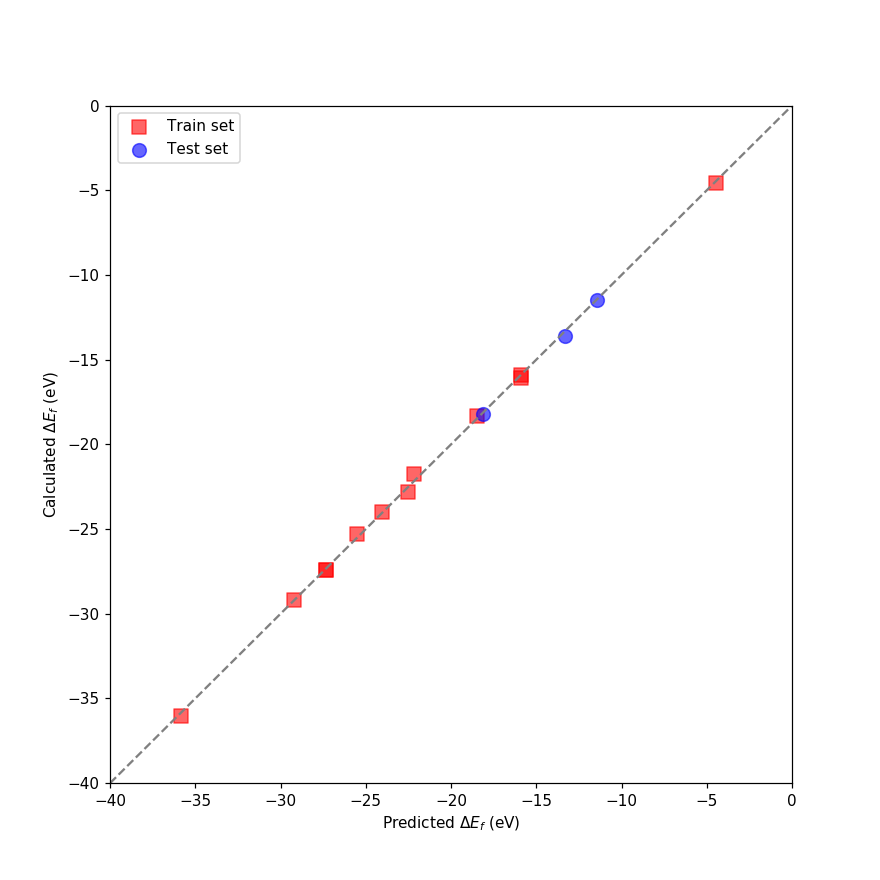

In [292]:
fig = plt.figure(figsize=(8,8))

plt.scatter(y_train_pred, y_train, marker='s', color='red', s=80, alpha=0.6, label='Train set')
plt.scatter(y_test_pred, y_test, marker='o', color='blue', s=80, alpha=0.6, label='Test set')
ini = -40
fim = 0
st = 10000
plt.plot(np.linspace(ini,fim,st), np.linspace(ini,fim,st), '--', c='gray')
plt.ylabel('Calculated $\Delta E_f$ (eV)')
plt.xlabel('Predicted $\Delta E_f$ (eV)')
plt.xlim(ini,fim)
plt.ylim(ini,fim)
# plt.ticklabel_format(axis='both', style='sci', scilimits=(-2,2),useMathText=True)
plt.legend()
plt.show()

Não tenho dúvidas que o modelo está bem treinado. Apesar de ter poucos (12) pontos para treinamento, o número de parâmetros a ser ajustado é menor (6, vide equação no começo). 

Por fim visualizamos os valores dos $\alpha_i$ obtidos do ajuste

In [293]:
print('-' * 2 + ' Cluster expansion parameters ' + '-' * 2)
l = ['E1', 'E2h', 'E2d', 'E3', 'E4d', 'E4f']
for i, j in zip(l, reg.coef_):
    print('{:4s} = {:8.3f}'.format(i, j))

-- Cluster expansion parameters --
E1   =   -0.892
E2h  =   -0.598
E2d  =   -0.536
E3   =   -0.242
E4d  =    0.356
E4f  =    0.052


Note que para estruturas maiores, do tipo quartetos, a contribuição da energia é positiva, levando o sistema para longe da estabilidade (energias negativas significam sistemas ligados!). Como esperado, as interações de pares são as mais significativas nesse modelo, logo após a energia das cadeias isoladas. A diferença entre $E_{2_h}$ e $E_{2_d}$ mostra a maior intensidade da interação de vdW em comparação com as pontes de hidrogênio.

### Parte 2 - Redução de dimensionalidade e visualização

Como temos 6 parâmetros que descrevem cada fibra, a informação contida no train e test sets reside em um espaço de 6 dimensões. Vou utilizar Principal Component Analysis - PCA - para diminuir a dimensionalidade destes conjuntos projetando-os em seus eixos de maior variância de informação. Verifico também que grande parte da variâncias está no primeiro eixo, como esperado.

In [294]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(X)

for i, j in enumerate(pca.explained_variance_ratio_):
    print('Variancia ao longo do eixo {:2d}: {:.3f}'.format(i, j))

Variancia ao longo do eixo  0: 0.980
Variancia ao longo do eixo  1: 0.016
Variancia ao longo do eixo  2: 0.004


Transformo os dados e visualizo em um plot 3D com as energias representadas pelo código de cores. Os DNAs das fibras foram adicionados acima dos pontos para melhor entendimento da tendência da energia com a configuração espacial das fibras.

<IPython.core.display.Javascript object>


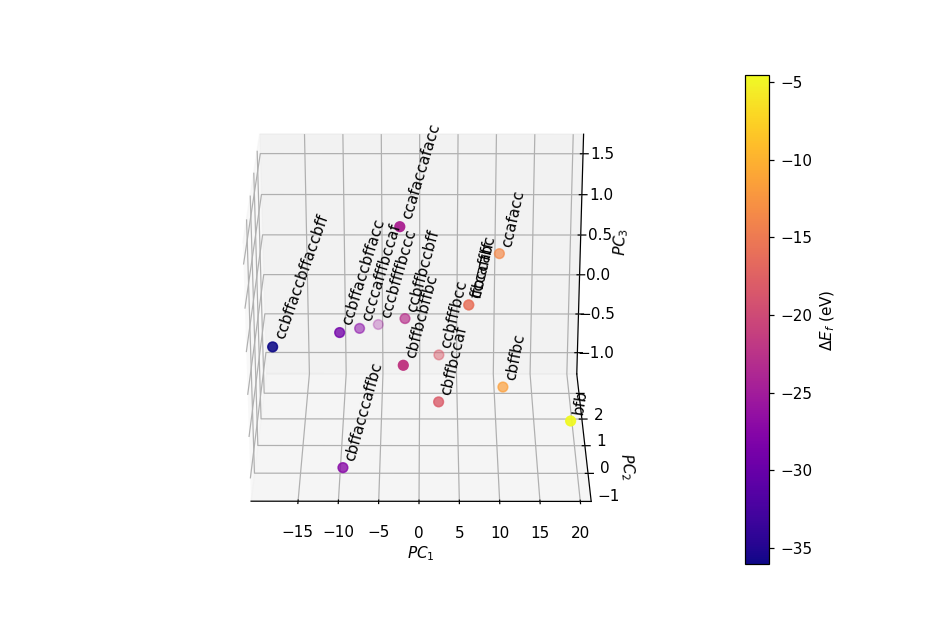

In [295]:
X_pca = pca.transform(X)

# print(X_pca)
# print(X_pca[:,2])

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sct = ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], cmap=plt.get_cmap('plasma'), c=y, s=40) #, alpha=0.1, c='black', edgecolors='none', s=30)
cbar = fig.colorbar(sct) #, shrink=0.5, aspect=5)
cbar.ax.set_ylabel('$\Delta E_f$ (eV)')
for i, j in zip(X_pca, labels):
    ax.text(i[0], i[1], i[2]+0.1, j, (1,1,0))

ax.set_xlabel('$PC_1$')
ax.set_ylabel('$PC_2$')
ax.set_zlabel('$PC_3$')


plt.show()

Note que as fibras maiores são as mais estáveis neste caso. A pergunta que fica é se existe uma configuração ideal para as fibras. Talvez seja possível obter essa informação da expressão da expansão em cluster agora que tenho os coeficientes da mesma.

### Parte 3 - Feature engineering

Agora vamos testar a regressão com menos features, para avaliar a importância de cada uma delas no resultado da regressão linear.

* Remoção de termo $E_1$

A expressão a ser ajustada agora na expansão de cluster é 

$$ \Delta E_f = \alpha_{2_h} n_{2_h} + \alpha_{2_d} n_{2_d}+ \alpha_{3} n_3 + \alpha_{4_d} n_{4_d} + \alpha_{4_l} n_{4_l}$$

In [296]:
# descriptors and targets in np arrays
y_new = np.array(energies, dtype=float)
X_new = np.array(desc, dtype=int)[:,1:]

print('Numero de dados: {:d}'.format(np.shape(X_new)[0]))
print('Dimensao dos descritores: {:d}'.format(np.shape(X_new)[1]))

# split train test sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

# separamos os labales do train e test sets aqui
lab_train = [labels[np.where(y == i)[0][0]] for i in y_train]
lab_test = [labels[np.where(y == i)[0][0]] for i in y_test]

Numero de dados: 15
Dimensao dos descritores: 5


Treinamos o regressor do mesmo modo que anteriormente

In [52]:
# linear regressor training
reg = LinearRegression().fit(X_train, y_train)

Verificamos o score deste regressor do mesmo modo, com a métrica do $R^2$.

In [53]:
# show score for train and test sets

score_train = reg.score(X_train, y_train)
score_test = reg.score(X_test, y_test)

print('Score train set: {:.8f}\nScore test set: {:.8f}'.format(score_train, score_test))

Score train set: 0.99938095
Score test set: 0.99644438


In [54]:
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

print('-' * 40 + ' Train set ' + '-' * 40)
for l, i,j in zip(lab_train, y_train, y_train_pred):
    print('DNA: {:20s} -> E calculada: {:9.3f}\tPredita: {:9.3f}\tAE: {:6.3f}%'.format(l, i, j, abs(i - j)*100/abs(i)))

print('\n' + '-' * 40 + ' Test set ' + '-' * 41)
for l, i,j in zip(lab_test, y_test, y_test_pred):
    print('DNA: {:20s} -> E calculada: {:9.3f}\tPredita: {:9.3f}\tAE: {:6.3f}%'.format(l, i, j, abs(i - j)*100/abs(i)))


---------------------------------------- Train set ----------------------------------------
DNA: bfb                  -> E calculada:    -4.564	Predita:    -4.445	AE:  2.602%
DNA: cbffbcbffbc          -> E calculada:   -21.726	Predita:   -22.178	AE:  2.080%
DNA: ccbffaccbffacc       -> E calculada:   -29.202	Predita:   -29.196	AE:  0.021%
DNA: ccbfffbcc            -> E calculada:   -18.307	Predita:   -18.481	AE:  0.947%
DNA: ccbffaccbffaccbff    -> E calculada:   -36.047	Predita:   -35.847	AE:  0.555%
DNA: cccaffbc             -> E calculada:   -15.889	Predita:   -15.895	AE:  0.037%
DNA: ccafaccafacc         -> E calculada:   -23.965	Predita:   -24.025	AE:  0.250%
DNA: ccccafffbccaf        -> E calculada:   -27.388	Predita:   -27.347	AE:  0.147%
DNA: ffbccaff             -> E calculada:   -16.085	Predita:   -15.895	AE:  1.179%
DNA: ccbffbccbff          -> E calculada:   -22.817	Predita:   -22.546	AE:  1.190%
DNA: cbffacccaffbc        -> E calculada:   -27.399	Predita:   -27.350	AE:  0.

Parece identico ao caso com 6 features... Vou tentar fazer uma comparação sistematica removendo os features 1 a 1

In [254]:
# descriptors and targets in np arrays
y = np.array(energies, dtype=float)


# print('Numero de dados: {:d}'.format(np.shape(X_new)[0]))
# print('Dimensao dos descritores: {:d}'.format(np.shape(X_new)[1]))

# create a number of train sets which are subsets of the original one
X_ex = [np.array(desc, dtype=int)[:,[1,2,3,4,5]],
     np.array(desc, dtype=int)[:,[0,2,3,4,5]],
     np.array(desc, dtype=int)[:,[0,1,3,4,5]],
     np.array(desc, dtype=int)[:,[0,1,2,4,5]],
     np.array(desc, dtype=int)[:,[0,1,2,3,5]],
     np.array(desc, dtype=int)[:,[0,1,2,3,4]]]

# store regressors here
reg = [LinearRegression() for i in range(len(X_ex))]

# store predictions here
y_train_pred_ex = []
y_test_pred_ex = []

# several train and test splittings are stored in these lists
X_train_ex = []
X_test_ex = []
y_train_ex = []
y_test_ex = []

# labels for each train-test split are stored here
lab_train = []
lab_test = []

# loop over regressors and X and y subsets
for i in range(len(reg)):
    # train test split is repeated for each regressor
    X_train, X_test, y_train, y_test = train_test_split(X_ex[i], y, test_size=0.2, random_state=1)
    
    # regressor is fitted for each subset X_train y_train
    reg[i].fit(X_train, y_train)
    
    # keep the train test splits for further use
    X_train_ex.append(X_train)
    X_test_ex.append(X_test)
    y_train_ex.append(y_train)
    y_test_ex.append(y_test)
    
    # separamos os labals do train e test sets aqui
    lab_train.append([labels[np.where(y == i)[0][0]] for i in y_train])
    lab_test.append([labels[np.where(y == i)[0][0]] for i in y_test])

    # prediction for each regressor are stored here
    y_train_pred_ex.append(reg[i].predict(X_train))
    y_test_pred_ex.append(reg[i].predict(X_test))

    
    print('\n##################\n# Regressor [{:2d}] #\n##################\n'.format(i+1))
    w = 'Coefficients: '
    for a in reg[i].coef_[:i]:
        w += '{:7.4f} '.format(a)
    w += ' **** '
    for a in reg[i].coef_[i:]:
        w += '{:7.4f} '.format(a)
    print(w)
    print('Intercept: {:7.4f}\n'.format(reg[i].intercept_))

    print('# Train set ... R^2 = {:6.4f}\n  Descriptor            Label       Predicted   Predicted'.format(reg[i].score(X_train, y_train)))
    print(59*'-')
    for j, k, l in zip(X_train, y_train, reg[i].predict(X_train)):
        w = '| '
        for a in j:
            w += '{:2d}  '.format(a)
        w += "| {:9.5f} | {:9.5f} | {:9.5f} |".format(k, l, 
                        np.sum([a * b for a, b in zip(reg[i].coef_, j)]) + reg[i].intercept_)
        
        print(w)
    print(59*'-')
    print('# Test set ... R^2 = {:6.4f}\n  Descriptor            Label       Predicted   Predicted'.format(reg[i].score(X_test, y_test)))
    print(59*'-')
    for j, k, l in zip(X_test, y_test, reg[i].predict(X_test)):
        w = '| '
        for a in j:
            w += '{:2d}  '.format(a)
        w += "| {:9.5f} | {:9.5f} | {:9.5f} |".format(k, l, 
                        np.sum([a * b for a, b in zip(reg[i].coef_, j)]) + reg[i].intercept_)
        
        print(w)
    print(59*'-')


##################
# Regressor [ 1] #
##################

Coefficients:  **** -1.1539 -1.0933 -0.3679  0.7860  0.3575 
Intercept:  1.0729

# Train set ... R^2 = 0.9994
  Descriptor            Label       Predicted   Predicted
-----------------------------------------------------------
|  7  12  10   3   8  | -18.30735 | -18.58524 | -18.58524 |
|  6  10   8   2   6  | -16.08481 | -16.00990 | -16.00990 |
|  8  16  12   4   8  | -23.96499 | -24.06204 | -24.06204 |
| 12  25  20   8  15  | -36.04686 | -35.81414 | -35.81414 |
|  1   4   2   1   0  |  -4.56364 |  -4.40392 |  -4.40392 |
|  6  13  10   4   7  | -18.19864 | -18.09600 | -18.09600 |
|  6  10   8   2   6  | -15.88926 | -16.00990 | -16.00990 |
|  4   8   6   2   4  | -11.46830 | -11.49458 | -11.49458 |
| 10  20  16   6  12  | -29.20223 | -29.21273 | -29.21273 |
|  8  15  12   4   9  | -22.81719 | -22.61131 | -22.61131 |
|  5   8   6   1   4  | -13.58684 | -13.43456 | -13.43456 |
|  7  16  12   5   8  | -21.72626 | -22.12206 | -22.1

Teste para ver se os regressores estão de fato fazendo algo diferente para cada subseção do espaço dos descritores.

In [282]:
# print coefficients and R^2 scores for each fit
print("Reg#  intercept      a1      a2      a3      a4      a5      a6  train R^2  test R^2")
for j, r in enumerate(reg):
    t = '  {:2d}    {:7.4f} '.format(j, reg[j].intercept_)
    for i in r.coef_[:j]:
        t += '{:7.4f} '.format(i)
    t+= ' ****** '
    for i in r.coef_[j:]:
        t += '{:7.4f} '.format(i)
    t += '   {:7.4f}   {:7.4f}'.format(reg[j].score(X_train_ex[j], y_train_ex[j]),
                                                       reg[j].score(X_test_ex[j], y_test_ex[j]))
    print(t)

Reg#  intercept      a1      a2      a3      a4      a5      a6  train R^2  test R^2
   0     1.0729  ****** -1.1539 -1.0933 -0.3679  0.7860  0.3575     0.9994    0.9479
   1     2.2792 -1.2063  ****** -0.4727 -0.3504  0.7337 -0.2282     0.9994    0.9479
   2     2.3626 -1.2898 -0.5930  ****** -0.5358  0.0572  0.1609     0.9994    0.9479
   3     2.0028 -0.9299 -0.6696 -0.5895  ******  0.3405 -0.0687     0.9994    0.9479
   4     2.1390 -1.0661 -0.8738 -0.2982 -0.1059  ******  0.0864     0.9994    0.9479
   5     2.0010 -0.9281 -0.6063 -0.5226 -0.2007  0.4056  ******     0.9994    0.9479


É um pouco estranho que os coeficientes ajustados em cada regressor sejam diferentes mas o R^2 tanto para o train quanto para o test sets é exatamente igual até a quarta casa depois da vírgula. O mesmo ocorre para os valores preditos, são extremamente próximos!

Eu fiz o teste para verificar se isso é um erro, simplesmente fazendo estes ajustes na unha (vide test_fit.py) e isso realmente acontece. Existe uma certa estabilidade dos resultados independentemente dos descritores usados. A minha explicação é que os valores dos descritores são parecidos, ou seja, são números inteiros em um intervalo entre 0 e 20 aproximadamente, o que faz com que a troca de uma coluna por outra no X leve a resultados parecidos. Matematicamente falando, eu imagino que existam inúmeros mínimos locais na minimização dos erros quadraticos médios neste caso, todas levando ao mesmo valor predito.

A única diferença que percebi dos ajustes aqui e neste script é que os coeficientes são muito dependentes do chute inicial para os mesmos (ver o vetor p0 de valores iniciais para o ajuste no test_fit.py). No entanto o valor predito é sempre o mesmo em todos os casos...

Vamos verificar os plots agora para cada um destes regressores

<IPython.core.display.Javascript object>


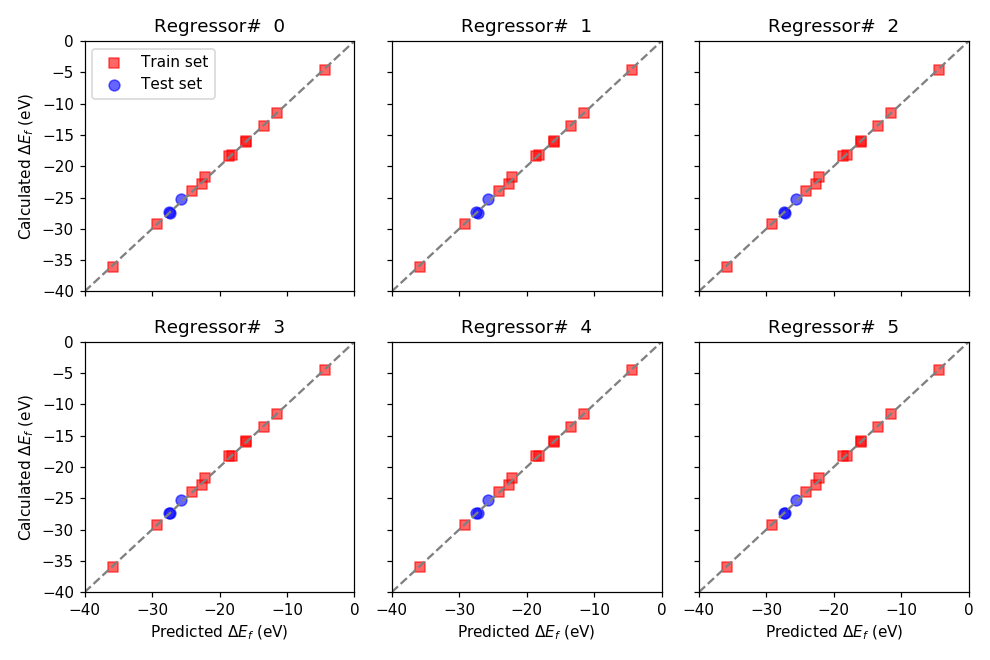

In [283]:
ncol, nrow = 3, 2

fig, axes = plt.subplots(ncols=ncol, nrows=nrow, figsize=(3*ncol, 3*nrow),sharex=True, sharey=True)

ini = -40
fim = 0
st = 10000

for i in range(nrow):
    for j in range(ncol):
        axes[i][j].scatter(y_train_pred_ex[i*ncol+j], 
                           y_train_ex[i*ncol+j], 
                           marker='s', 
                           color='red', 
                           s=50, 
                           alpha=0.6, 
                           label='Train set')
        axes[i][j].scatter(y_test_pred_ex[i*ncol+j], 
                           y_test_ex[i*ncol+j], 
                           marker='o', 
                           color='blue', 
                           s=50, 
                           alpha=0.6, 
                           label='Test set')
        axes[i][j].plot(np.linspace(ini,fim,st),
                        np.linspace(ini,fim,st),
                        '--',
                        c='gray')
        axes[i][j].set_title("Regressor# {:2d}".format(i*ncol+j))

axes[0][0].set_ylabel('Calculated $\Delta E_f$ (eV)')
axes[1][0].set_ylabel('Calculated $\Delta E_f$ (eV)')

axes[1][0].set_xlabel('Predicted $\Delta E_f$ (eV)')
axes[1][1].set_xlabel('Predicted $\Delta E_f$ (eV)')
axes[1][2].set_xlabel('Predicted $\Delta E_f$ (eV)')

axes[0][0].set_xlim(ini,fim)
axes[0][0].set_ylim(ini,fim)
# plt.ticklabel_format(axis='both', style='sci', scilimits=(-2,2),useMathText=True)
axes[0][0].legend()
plt.tight_layout()
plt.show()

Parecem bons... Vamos ver o PCA de cada um deles agora

------------ PCA#  1 ---------------
Variancia ao longo do eixo  0: 0.979
Variancia ao longo do eixo  1: 0.018
Variancia ao longo do eixo  2: 0.003
------------ PCA#  2 ---------------
Variancia ao longo do eixo  0: 0.983
Variancia ao longo do eixo  1: 0.012
Variancia ao longo do eixo  2: 0.004
------------ PCA#  3 ---------------
Variancia ao longo do eixo  0: 0.978
Variancia ao longo do eixo  1: 0.016
Variancia ao longo do eixo  2: 0.006
------------ PCA#  4 ---------------
Variancia ao longo do eixo  0: 0.974
Variancia ao longo do eixo  1: 0.021
Variancia ao longo do eixo  2: 0.005
------------ PCA#  5 ---------------
Variancia ao longo do eixo  0: 0.984
Variancia ao longo do eixo  1: 0.013
Variancia ao longo do eixo  2: 0.003
------------ PCA#  6 ---------------
Variancia ao longo do eixo  0: 0.984
Variancia ao longo do eixo  1: 0.014
Variancia ao longo do eixo  2: 0.002


<IPython.core.display.Javascript object>


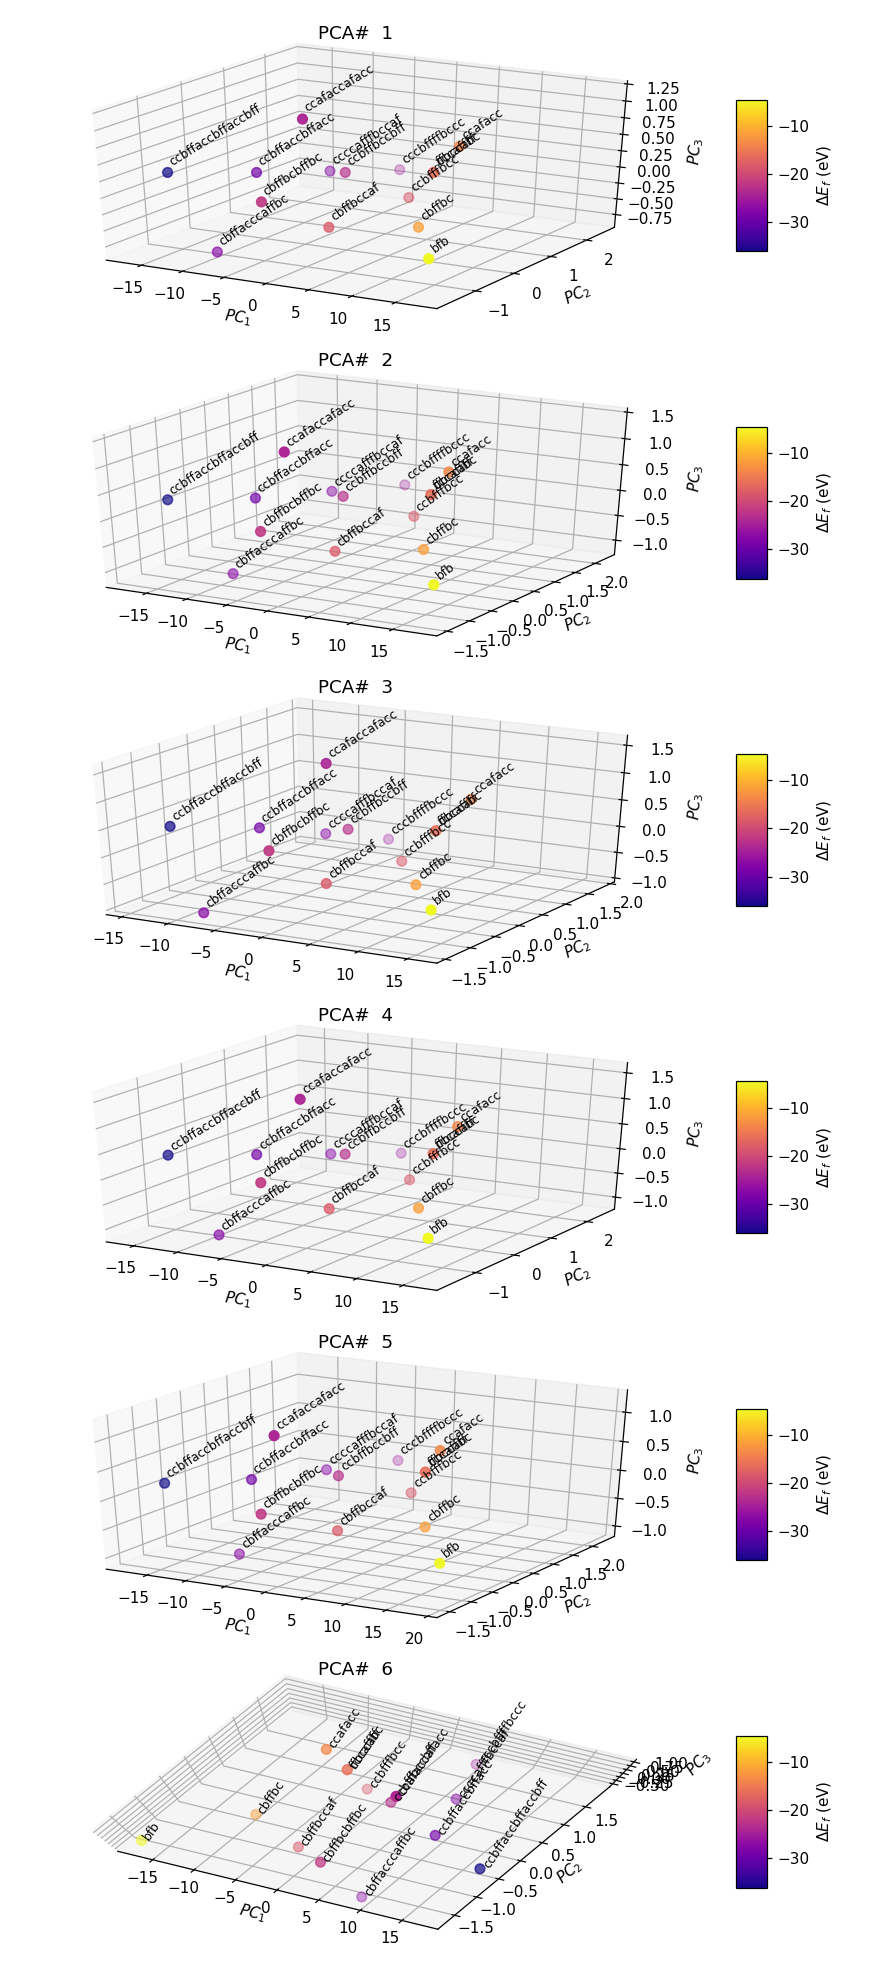

In [192]:
# store each PCA in this list
pcas = [PCA(n_components=3) for i in range(len(X_ex))]

# store transformed datasets here
X_pca = []

# loop over subsets of X
for i in range(len(X_ex)):
    # fit the PCAs
    pcas[i].fit(X_ex[i])

    print("------------ PCA# {:2d} ---------------".format(i+1))
    for k, j in enumerate(pcas[i].explained_variance_ratio_):
        print('Variancia ao longo do eixo {:2d}: {:.3f}'.format(k, j))

    X_pca.append(pcas[i].transform(X_ex[i]))

fig = plt.figure(figsize=(8, 3*len(pcas)))
for i in range(len(pcas)):
    ax = fig.add_subplot(len(pcas), 1, i+1, projection='3d')
    sct = ax.scatter(X_pca[i][:,0], 
                     X_pca[i][:,1], 
                     X_pca[i][:,2], 
                     cmap=plt.get_cmap('plasma'), 
                     c=y, 
                     s=40) #, alpha=0.1, c='black', edgecolors='none', s=30)
#     if i == 2 or i == 5:
    cbar = fig.colorbar(sct, shrink=0.5, aspect=5)
    cbar.ax.set_ylabel('$\Delta E_f$ (eV)')
    for k, j in zip(X_pca[i], labels):
        ax.text(k[0], k[1], k[2]+0.1, j, (1,1,0), size=8)

    ax.set_title("PCA# {:2d}".format(i+1))
    ax.set_xlabel('$PC_1$')
    ax.set_ylabel('$PC_2$')
    ax.set_zlabel('$PC_3$')

plt.tight_layout()
plt.show()

Apenas of PCA# 6 parece ser diferente dos outros... mas a distribuição dos pontos e suas energias parecem seguir rampas parecidas em todos. Vou adicionar agora features quadraticas para verificar se acho um spot de estabilidade nos dados

Vou tentar uma solução radical para entender a importância dos descritores: usar apenas os termos de single chain e pares na expansão de clusters

In [287]:
# create a number of train sets which are subsets of the original one
X_sp = np.array(desc, dtype=int)[:,[0,1,2]]

print('Numero de dados: {:d}'.format(np.shape(X_sp)[0]))
print('Dimensao dos descritores: {:d}'.format(np.shape(X_sp)[1]))

# split train test sets
X_train, X_test, y_train, y_test = train_test_split(X_sp, y, test_size=0.2, random_state=42)

# separamos os labels do train e test sets aqui
lab_train = [labels[np.where(y == i)[0][0]] for i in y_train]
lab_test = [labels[np.where(y == i)[0][0]] for i in y_test]

# linear regressor training
reg = LinearRegression().fit(X_train, y_train)

# show score for train and test sets

score_train = reg.score(X_train, y_train)
score_test = reg.score(X_test, y_test)

print('\nScore train set: {:6.3f}\nScore test set:  {:6.3f}'.format(score_train, score_test))

Numero de dados: 15
Dimensao dos descritores: 3

Score train set:  0.999
Score test set:   0.996
